In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten

import matplotlib.pyplot as plt
import tikzplotlib
import pylab
from mpl_toolkits.mplot3d import Axes3D

In [48]:
# Construct model
model = Sequential()
model.add(Dense(100, input_shape=[2,], activation='selu'))
model.add(Dense(100, activation='selu'))
model.add(Dense(100, activation='selu'))
model.add(Dense(100, activation='selu'))
model.add(Dense(100, activation='selu'))
model.add(Dense(100, activation='selu'))
model.add(Flatten())
model.add(Dense(1))

In [37]:
def theta2cart(theta_out, r): # converts random thetas and fixed r into x and y coordinates
    x_out = tf.math.scalar_mul(r, tf.math.cos(theta_out)) # x = 4cos(theta_in)
    y_out = tf.math.scalar_mul(r, tf.math.sin(theta_out)) # y = 4sin(theta_in)
    
    out_bnd_pts = tf.transpose(tf.stack([x_out,y_out],0))
    return out_bnd_pts

In [38]:
def out_bnd_fn(theta_out): # f(4,theta) = 4sin(5theta)
    f_true = tf.transpose(tf.math.scalar_mul(4, tf.math.sin(tf.math.scalar_mul(5,theta_out))))
    return f_true

In [39]:
def loss_fn(f_pred, theta_out): # loss_fn(model, [x,y], [theta_in], [theta_out])
#     f_pred = tf.squeeze(f_pred)
#     print("f_pred shape" ,tf.shape(f_pred))

# Find loss for outer boundary points #####################################################################
    f_true =  out_bnd_fn(theta_out)
#     f_true = tf.squeeze(f_true)
#     print("t_true shape", tf.shape(f_true))

# out_bnd_err = f(x,y)-4sin(5theta)

    loss = tf.keras.metrics.mean_squared_error(f_true,f_pred) # MSE outer bound points
    return loss

In [57]:
# Train network
def train_for():
    #Ftrl
    #Adam BAD
    #SGD BAD
    #Nadam BAD

# Define training parameters ##############################################################################    
    optimizer = tf.keras.optimizers.Ftrl(learning_rate=0.1) # Fancy gradient decent
    epochs = 200
    train_loss_results = [] # For tracking loss during training
    iterations_per_epoch = 100

    theta_out_size = 100 # Number of outer boundary points to sample each iteration

    for epoch in range(epochs):
        epoch_loss_avg = tf.keras.metrics.Mean()
        
        for iteration in range(iterations_per_epoch):
    
# Sample outer bound thetas ###############################################################################
            theta_out = tf.random.uniform([1,theta_out_size], minval=0, maxval=2*np.pi)
            out_bnd_pts = theta2cart(theta_out,4)
            
# Optimize the network with respect to hyperparameters ####################################################
            
            with tf.GradientTape() as t:
                f_pred = model(out_bnd_pts, training=True)
                loss = loss_fn(f_pred, theta_out) # Loss
            grads = t.gradient(loss, model.trainable_weights) # Find model gradients
            optimizer.apply_gradients(zip(grads, model.trainable_weights)) # Perform gradient decent
            epoch_loss_avg.update_state(loss) # Track loss
            #optimizer.minimize(loss_fn(model, theta_out), model.trainable_weights)
            # End training iteration
        train_loss_results.append(epoch_loss_avg.result())
        
        if epoch % 1 == 0:
            print("Epoch {:03d}: Loss: {:.3f}".format(epoch, epoch_loss_avg.result()))
        # End Epoch

In [58]:
train_for()

Epoch 000: Loss: 13969.657
Epoch 001: Loss: 5.013
Epoch 002: Loss: 3.798
Epoch 003: Loss: 3.073
Epoch 004: Loss: 2.627
Epoch 005: Loss: 2.358
Epoch 006: Loss: 2.161
Epoch 007: Loss: 1.961
Epoch 008: Loss: 1.769
Epoch 009: Loss: 1.713
Epoch 010: Loss: 1.561
Epoch 011: Loss: 1.477
Epoch 012: Loss: 1.395
Epoch 013: Loss: 1.326
Epoch 014: Loss: 1.271
Epoch 015: Loss: 1.163
Epoch 016: Loss: 1.105
Epoch 017: Loss: 1.056
Epoch 018: Loss: 0.974
Epoch 019: Loss: 0.917
Epoch 020: Loss: 0.920
Epoch 021: Loss: 0.819
Epoch 022: Loss: 0.812
Epoch 023: Loss: 0.763
Epoch 024: Loss: 0.714
Epoch 025: Loss: 0.685
Epoch 026: Loss: 0.700
Epoch 027: Loss: 0.646
Epoch 028: Loss: 0.642
Epoch 029: Loss: 0.580
Epoch 030: Loss: 0.559
Epoch 031: Loss: 0.550
Epoch 032: Loss: 0.503
Epoch 033: Loss: 0.519
Epoch 034: Loss: 0.450
Epoch 035: Loss: 0.440
Epoch 036: Loss: 0.426
Epoch 037: Loss: 0.415
Epoch 038: Loss: 0.395
Epoch 039: Loss: 0.371
Epoch 040: Loss: 0.341
Epoch 041: Loss: 0.321
Epoch 042: Loss: 0.324
Epoch 0

In [59]:
# Generate test points to plot ############################################################################
out_bnd_pts_size = 1000 # Number of outer boundary points to sample 

# Sample outer boundary points ############################################################################
theta_out = tf.random.uniform([1, out_bnd_pts_size], minval=0, maxval=2*np.pi)
test_pts = theta2cart(theta_out,4)
# print(test_pts)
print("test_pts shape",tf.shape(test_pts))

z_pred = model(test_pts)
print("z_pred shape", tf.shape(z_pred))

z = out_bnd_fn(theta_out)
print("z shape",tf.shape(z))


test_pts shape tf.Tensor([1000    1    2], shape=(3,), dtype=int32)
z_pred shape tf.Tensor([1000    1], shape=(2,), dtype=int32)
z shape tf.Tensor([1000    1], shape=(2,), dtype=int32)


(1000,)
(1000,)
(1000,)


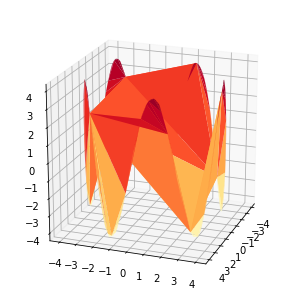

In [60]:
# Plot ####################################################################################################
fig = pylab.figure(figsize=plt.figaspect(1))
ax = Axes3D(fig)

X = test_pts[0:, 0, 0].numpy()
print(X.shape)
Y = test_pts[0:, 0, 1].numpy()
print(Y.shape)
Z = z_pred[0:, 0].numpy()
print(Z.shape)

ax.plot_trisurf(X,Y,Z, cmap=plt.cm.YlOrRd)
ax.view_init(20, 20)
plt.show()

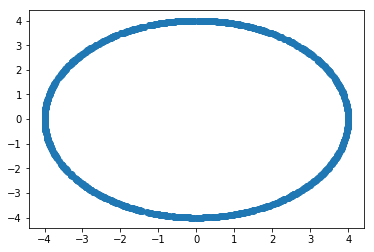

In [61]:
plt.scatter(X,Y)
plt.show()